In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import os
from scipy import sparse

In [2]:
os.chdir("path")

In [3]:
kMin = 10**-2
kMax = 4
kNum = 100
kGrid = np.linspace(kMin, kMax, kNum)
theta = 0.67
delta = 0.13
beta = 0.98

hNum = kNum
hGrid = np.linspace(0.01, 0.99, hNum)
kappa = 5.24
nu = 2

In [4]:
@np.vectorize
def utility(k, kPrime):

    return np.log(k**(1-theta) + (1-delta)*k - kPrime)

@np.vectorize
def cons( k, kPrime):

    return k**(1-theta) +(1-delta)*k - kPrime

@np.vectorize
def utilityLab(k, kPrime, h):

    return np.log(k**(1-theta)* h**theta + (1-delta)*k - kPrime) \
           - kappa*(h**(1 + 1/nu)/ 1 + 1/nu)

@np.vectorize
def consLab(k, kPrime, h):

    return k**(1-theta) * h**theta +(1-delta)*k - kPrime


In [5]:
def Util():
    """
    Define M as u (f (ki ) + (1 -\delta)ki - kj )
    Impose the constraints on capital through C
    s.t. kj =< f (ki) + (1 - \delta)ki
    """

    V = np.zeros(kNum)
    M = np.zeros((kNum, kNum))

    for (idi, k) in enumerate(kGrid):
        for (idj, kPRime) in enumerate(kGrid):

            M[idi, idj] = utility(k, kPRime)

    C = np.zeros((kNum, kNum))

    for (idi, k) in enumerate(kGrid):
        for (idj, kPRime) in enumerate(kGrid):

            C[idi, idj] = cons(k, kPRime)

    M[C < 0] = -500

    return V, M
V, M = Util()

<ipython-input-4-c65ac2701260>:4: RuntimeWarning: invalid value encountered in log
  return np.log(k**(1-theta) + (1-delta)*k - kPrime)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [6]:
%%time
"""
Discrete case with exogenous labour supply
"""

X = np.zeros(np.shape(M))
for i in range(len(V)):
        X[:, i] = M[:, i] + beta*V[i]

V1 = X.max(axis=1)

OptimalPath = [V, V1]
PRule = []
niter = 0
while np.linalg.norm(V1 - V) > 10**-4 and niter < 275:

    for i in range(len(V)):
        X[:, i] = M[:, i] + beta*V1[i]

    V1 = X.max(axis=1)

    g = []
    for i in V1:
        idx = np.where(X == i)[1]
        g.append(kGrid[idx])
        PRule.append(g)

    OptimalPath.append(V1)
    V1 = OptimalPath[-1]
    V = OptimalPath[-2]

    niter = niter+1

Wall time: 1.75 s


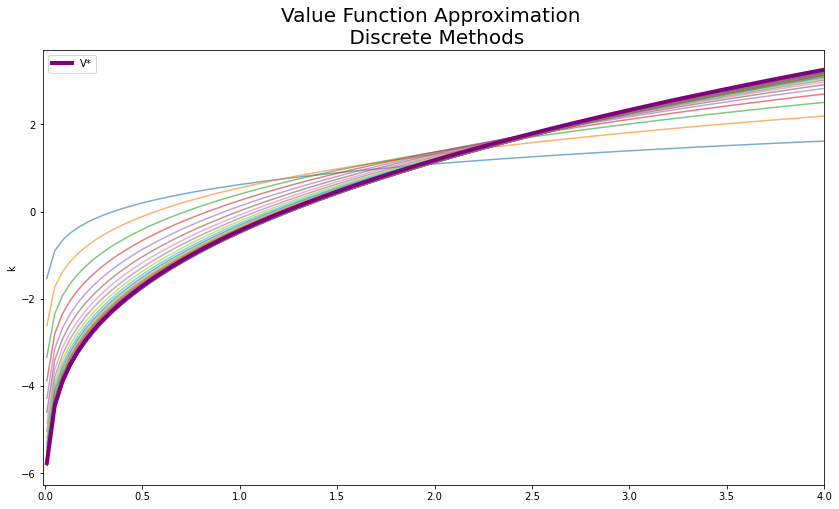

In [7]:
fig, ax = plt.subplots(facecolor="w", figsize=(14, 8))
for i in OptimalPath[1:-1]:
    ax.plot(kGrid, i, zorder=10, alpha=0.6)
ax.plot(kGrid, OptimalPath[-1], label="V*", linewidth=4, c="purple", zorder=50)
plt.title("Value Function Approximation \n Discrete Methods", fontsize=20)
plt.ylabel("k")
plt.xlim((-0.01, 4))
plt.legend()

#fig.savefig("Title Graph")

In [8]:
def Plot(kGrid, V1, g, title="Set", filename="set"):

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, facecolor="w", figsize=(14,6))
    fig.suptitle(title, fontsize=20, c="darkblue")
    ax1.plot(kGrid, V1, lw=2, c="darkgreen")
    ax1.set_title("Value Function",c="darkblue")
    ax1.set_xlim((0, 4))

    ax2.plot(kGrid, g, lw=2,c="darkgreen")
    ax2.set_title("Policy Function",c="darkblue")
    ax2.set_xlim((0, 4))

    fig.savefig(filename)

#fig = Plot(kGrid, V1, g, title="Value Function Approximation \n Brute Force",
           #filename="Brute Force")

In [9]:
"""
speed improvements!
"""

'\nspeed improvements!\n'

In [10]:
%%time
"""
Concavity!
"""

"""
Discrete case with exogenous labour supply
"""

V1 = np.zeros(kNum)

X = np.ones(np.shape(M))*-500
for i in range(len(X)):
    for j in range(len(X)):
        if j == 0:
            X[i, j] = M[i, j] + beta* V[j]
        else:
            X[i, j] = M[i, j] + V[j]
            if X[i, j-1] > X[i, j]:
                V1[i] = X[i, j-1]
                break

OptimalPath = [V, V1]
PRule = []
niter = 0
while np.linalg.norm(V1 - V) > 10**-4 and niter < 275:

    Vs = np.zeros(kNum)
    X = np.ones(np.shape(M))*-500
    for i in range(len(X)):
        for j in range(len(X)):
            if j == 0:
                X[i, j] = M[i, j] + beta * V1[j]
            else:
                X[i, j] = M[i, j] + V1[j]
                if X[i, j-1] > X[i, j]:
                    Vs[i] = X[i, j-1]
                    break

    g = []
    for i in Vs[:-1]:
        idx = np.where(X == i)[1]
        g.append(kGrid[idx])
        PRule.append(g)

    OptimalPath.append(Vs)
    V1 = OptimalPath[-1]
    V = OptimalPath[-2]
    niter = niter+1

Wall time: 3.9 s


In [11]:
#Plot(kGrid[:-1], V1[:-1], g, title="Value Function Approximation \n Speeding Concavity",
     #filename="Concavity")



In [12]:
%%time
"""
Monotonicity of the policy function
"""

"""
Discrete case with exogenous labour supply
"""

V1 = np.zeros(kNum)

X = np.zeros(np.shape(M))
for i in range(len(X)):
    for j in range(len(X)):
            X[i, j] = M[i, j] + beta * beta * V[j]


V1 = X.max(axis=1)

PRule = []
g = np.zeros(kNum)
for idv,i in enumerate(V1):
    idx = np.where(X == i)[1]
    g[idv] = kGrid[idx]
    PRule.append(g)

kLB = np.zeros(kNum)
kLB[0] = g[0]


OptimalPath = [V, V1]
niter = 0

while np.linalg.norm(V1 - V) > 10**-4 and niter < 275:
    
    for i in range(1, kNum):
        kLB[i] = g[i-1]

    X = np.ones(np.shape(M))*-500
    for i in range(len(X)):
        for j in range(len(X)):
            if kGrid[j] >= kLB[i]:
                X[i, j] = M[i, j] + beta * V1[j]
    
    V1 = X.max(axis=1)

    g = np.zeros(kNum)
    for idv, i in enumerate(V1):
        idx = np.where(X == i)[1]
        g[idv] = kGrid[idx]
        PRule.append(g)

    OptimalPath.append(V1)
    V1 = OptimalPath[-1]
    V = OptimalPath[-2]
    niter = niter+1

Wall time: 4.07 s


In [13]:
#Plot(kGrid, V1, g, title="Value Function Approximation \n Speeding Monotonicity",
     #filename="Monotonicity")


In [14]:
%%time
"""
Monotonicity and concavity
"""

V = np.zeros(kNum)
M = np.zeros((kNum, kNum))

for (idi, k) in enumerate(kGrid):
    for (idj, kPRime) in enumerate(kGrid):

        M[idi, idj] = utility(k, kPRime)

C = np.zeros((kNum, kNum))

for (idi, k) in enumerate(kGrid):
    for (idj, kPRime) in enumerate(kGrid):

        C[idi, idj] = cons(k, kPRime)

M[C < 0] = -500

V1 = np.zeros(kNum)

X = np.zeros(np.shape(M))*-500
for i in range(len(X)):
    for j in range(len(X)):
        if j == 0:
            X[i, j] = M[i, j] + beta * V[j]
        else:
            X[i, j] = M[i, j] + beta * V[j]
            if X[i, j-1] > X[i, j]:
                V1[i] = X[i, j-1]
                break

PRule = []
g = np.zeros(kNum)
for idv,i in enumerate(V1):
    idx = np.where(X == i)[1]
    g[idv] = kGrid[idx]
    PRule.append(g)

kLB = np.zeros(kNum)
kLB[0] = g[0]

OptimalPath = [V, V1]
PRule = []
niter = 0
while np.linalg.norm(V1 - V) > 10**-4 and niter < 275:


    for i in range(1, kNum):
        kLB[i] = g[i-1]


    Vs = np.zeros(kNum)
    X = np.ones(np.shape(M))*-500
    for i in range(len(X)):
        for j in range(len(X)):
            if j == 0:
                    X[i, j] = M[i, j] + beta * V1[j]
            else:
                if kGrid[j] >= kLB[j]:
                    X[i, j] = M[i, j] + beta * V1[j]
                if X[i, j-1] > X[i, j]:
                    Vs[i] = X[i, j-1]
                    break

    g = []
    for i in Vs:
        idx = np.where(X == i)[1]
        g.append(kGrid[idx])
        PRule.append(g)

    OptimalPath.append(Vs)
    V1 = OptimalPath[-1]
    V = OptimalPath[-2]
    niter = niter+1

<ipython-input-4-c65ac2701260>:4: RuntimeWarning: invalid value encountered in log
  return np.log(k**(1-theta) + (1-delta)*k - kPrime)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


Wall time: 2.7 s


In [15]:
#Plot(kGrid, V1, g, title="Speeding with Monotonicity & Concavity",
     #filename="Mono and Conv")

In [16]:
%%time

"""
Local Search !!!

Discrete case with exogenous labour supply
"""


X = np.zeros(np.shape(M))
for i in range(len(V)):
        X[:, i] = M[:, i] + beta*V[i]

V1 = X.max(axis=1)
g = []
PRule = []
for i in V1:
    idx = np.where(X == i)[1]
    g.append(kGrid[idx])
    PRule.append(g)


OptimalPath = [V, V1]

niter = 0
while np.linalg.norm(V1 - V) > 10**-4 and niter < 275:

    X = -500*(np.ones(np.shape(M)))
    for i in range(kNum):
        if i == 0:
            for j in range (i, i+8):
                X[j, i] = M[j, i] + beta*V1[i]
        if i == 1:
            for j in range (i-1, i+7):
                X[j, i] = M[j, i] + beta*V1[i]
        if i == 2:
            for j in range (i-2, i+6):
                X[j, i] = M[j, i] + beta*V1[i]
        if i == 3:
            for j in range (i-3, i+5):
                X[j, i] = M[j, i] + beta*V1[i]
        if i in range (4, 96):
            for j in range (i-4, i+4):
                X[j, i] = M[j, i] + beta*V1[i]
        if i == 97:
            for j in range (i-5, i+3):
                X[j, i] = M[j, i] + beta*V1[i]
        if i == 98:
            for j in range (i-6, i+2):
                X[j, i] = M[j, i] + beta*V1[i]
        if i == 99:
            for j in range (i-7, i+1):
                X[j, i] = M[j, i] + beta*V1[i]
        if i == 100:
            for j in range (i-8, i):
                X[j, i] = M[j, i] + beta*V1[i]

    V1 = X.max(axis=1)

    g = []
    for i in V1:
        idx = np.where(X == i)[1]
        g.append(kGrid[idx])
        PRule.append(g)

    OptimalPath.append(V1)
    V1 = OptimalPath[-1]
    V = OptimalPath[-2]

    niter = niter+1

Wall time: 1.75 s


In [17]:
#Plot(kGrid, V1, g, title="Value Function Approximation \n Speeding with Local Search", filename="Line Search")